In [3]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
# from tqdm import tqdm
from pprint import pprint
from src.stereo_calibration_utils import *
from src.cameras import *
%load_ext autoreload
%autoreload 2

# Introduction

We assume you have followed the hardware setup and camera calibration tutorial to collect the data used in this notebook or you have a copy of the sample dataset provided in the repository. With this, this notebook aims to estimate the relative pose of the multi-camera tracker cameras with respect to each other which is a required step before we can use the system to track our objects! 

The procedure described here does not rely on any kind of fiducial or chessboards, and does not assume co-visibility throughout the whole dataset. Instead, we use our inferred stick to generate a dataset from the random movement of a marker in front of the cameras. 

# Step0: Load the Dataset and Camera Intrinsic Parameters
Here we want a manager class to hold the seen markers through the tracker cameras, the time stamps of the observations and the parameters of the camera.

In [5]:
dataset_dir = 'sample_dataset/multi-camera-calibration-dataset.pckl'
camera_intrinsic_dir = 'sample_dataset/intrinsics/'

cam_dm = cameraDataManager(dataset_dir, camera_intrinsic_dir,
                           ports = [5000, 5001, 5002], data_idx= 3)  

synchronized_paths = cam_dm.getSynchronizedSamples('5002-0')
synchronized_paths.keys()

dict_keys(['5000-0', '5000-1', '5001-0', '5001-1', '5002-0', '5002-1'])

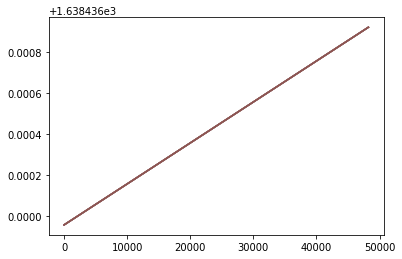

In [3]:
for key in cam_dm.pixel_locations.keys():
    plt.plot(cam_dm.stamp_per_camera[key][cam_dm.syncMap('5002-0',key)[:,1]])

# Step1: Geometrical Stereo Extrinsics

For the first step, we use the epipolar constraints between each pair of camera in the system to compute their extrinsic parameters with respect to each other. The geometric solution of this is based on estimating the fundamental and essential matrices that correspond to an identical marker observed by two cameras.

First, we make a list of all possible camera pairs. We distinguish each camera node in the system with *port_number-camera_id* designators where *camera_port* is the UDP port from which we received the marker locations and the *camera_id* is the camera number attached to that port. 

In [7]:
cam_keys = [key for key in cam_dm.pixel_locations.keys()]
camera_pairs = []
for i in range(len(cam_keys)-1):
    for j in range(i+1, len(cam_keys)):
#         if cam_keys[i] !='5000-0' and cam_keys[j] !='5000-0':
        camera_pairs.append([cam_keys[i], cam_keys[j]])
camera_pairs

[['5000-0', '5000-1'],
 ['5000-0', '5001-0'],
 ['5000-0', '5001-1'],
 ['5000-0', '5002-0'],
 ['5000-0', '5002-1'],
 ['5000-1', '5001-0'],
 ['5000-1', '5001-1'],
 ['5000-1', '5002-0'],
 ['5000-1', '5002-1'],
 ['5001-0', '5001-1'],
 ['5001-0', '5002-0'],
 ['5001-0', '5002-1'],
 ['5001-1', '5002-0'],
 ['5001-1', '5002-1'],
 ['5002-0', '5002-1']]

Then, we use a the **StereoGeometricalCalibrator** class to estimate the extrinsic parameters between each of the pairs shown above. 

the product turned out negative
['5000-0', '5000-1']


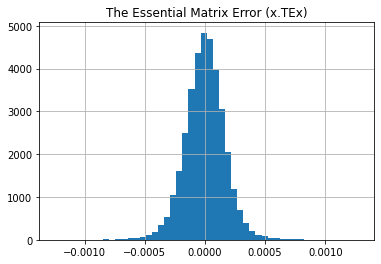

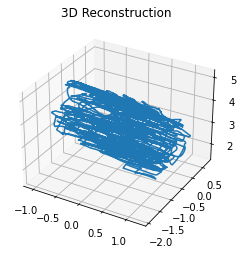

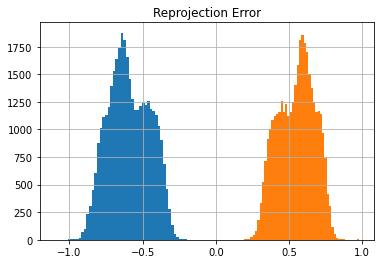

-----------------------------------------
the product turned out negative
['5000-0', '5001-0']


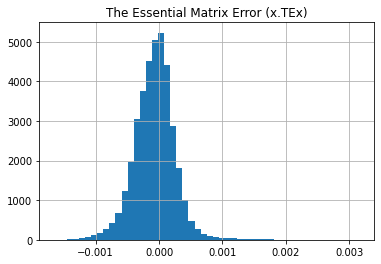

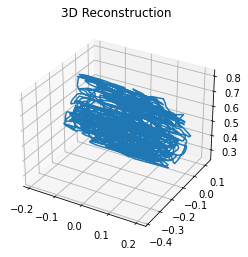

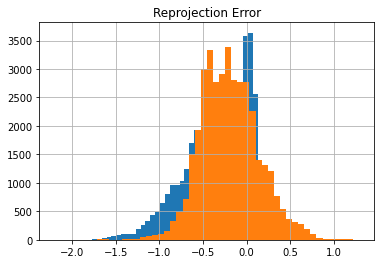

-----------------------------------------
['5000-0', '5001-1']


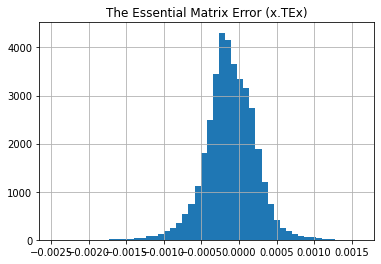

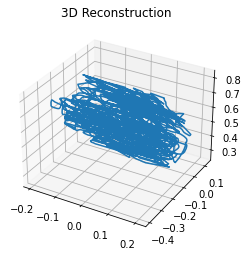

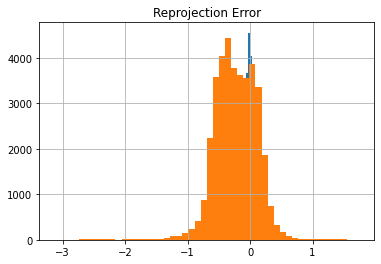

-----------------------------------------
['5000-0', '5002-0']


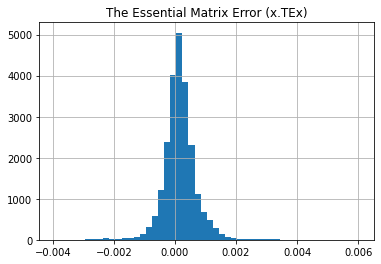

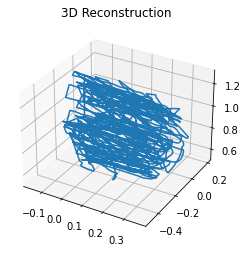

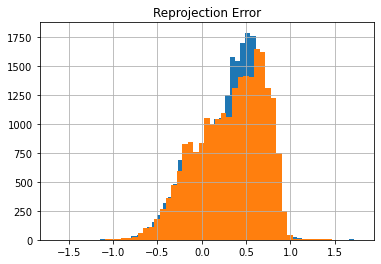

-----------------------------------------
['5000-0', '5002-1']


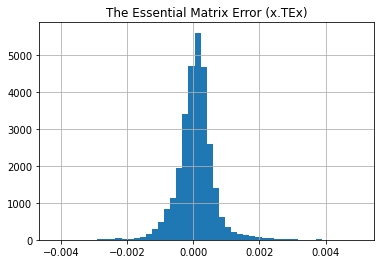

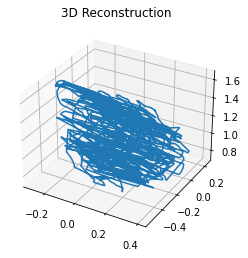

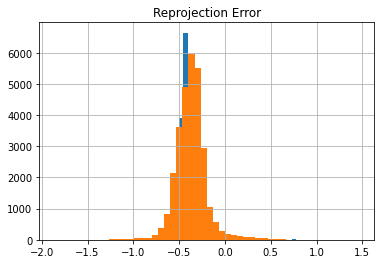

-----------------------------------------
the product turned out negative
['5000-1', '5001-0']


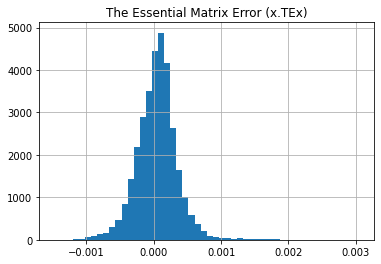

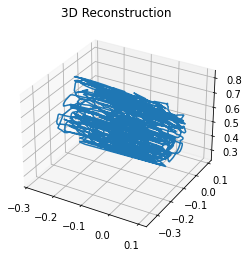

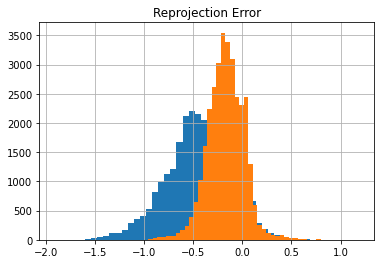

-----------------------------------------
the product turned out negative
['5000-1', '5001-1']


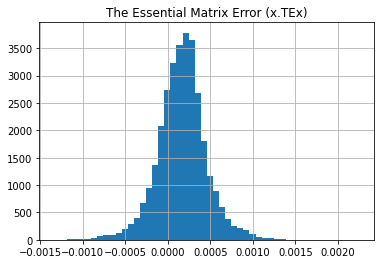

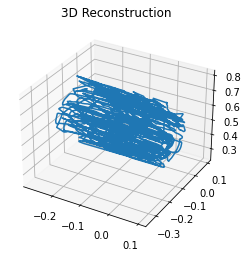

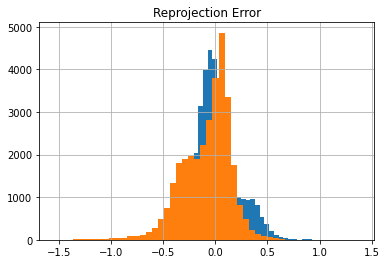

-----------------------------------------
['5000-1', '5002-0']


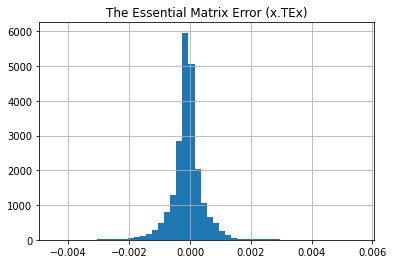

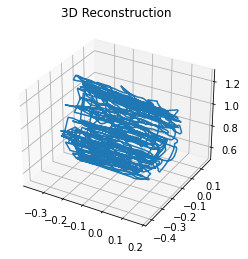

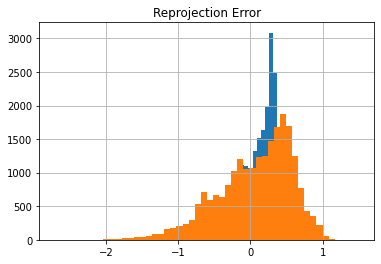

-----------------------------------------
['5000-1', '5002-1']


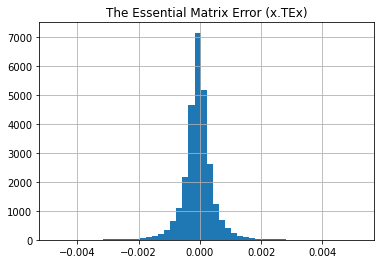

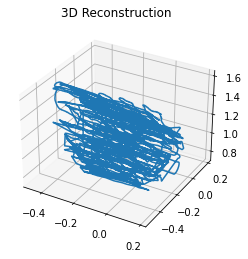

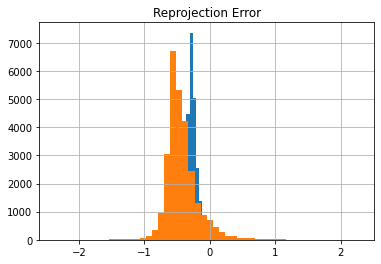

-----------------------------------------
['5001-0', '5001-1']


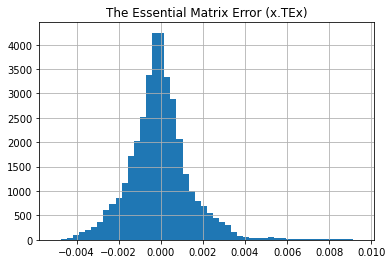

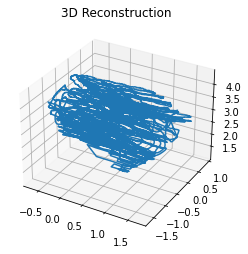

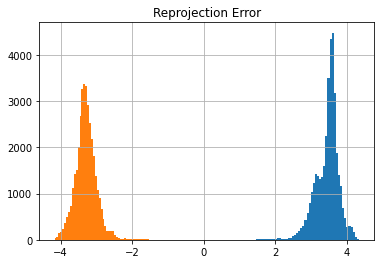

-----------------------------------------
the product turned out negative
['5001-0', '5002-0']


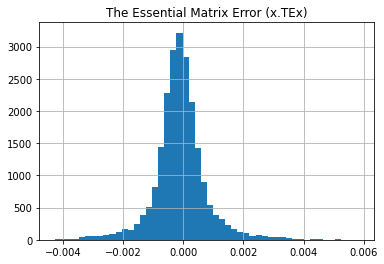

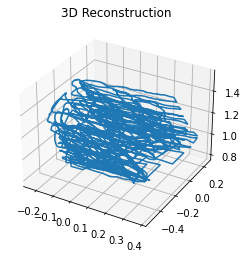

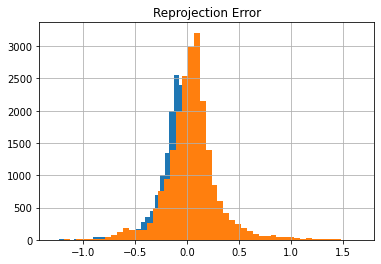

-----------------------------------------
['5001-0', '5002-1']


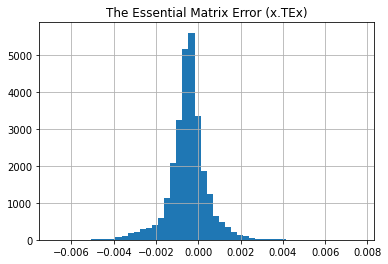

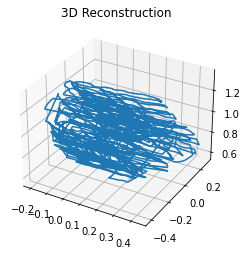

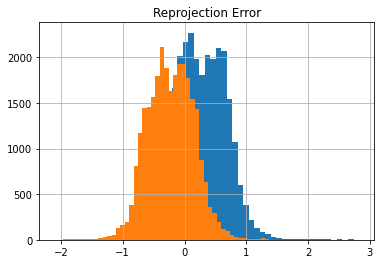

-----------------------------------------
['5001-1', '5002-0']


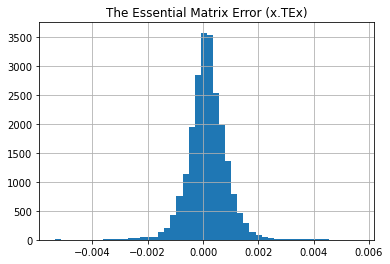

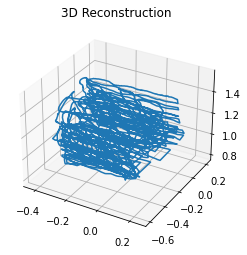

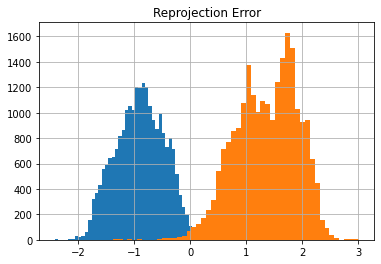

-----------------------------------------
the product turned out negative
['5001-1', '5002-1']


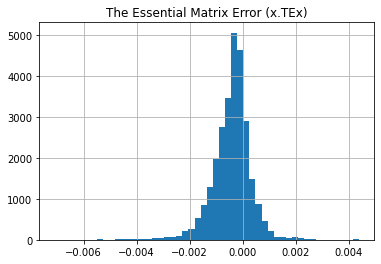

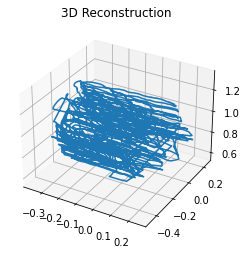

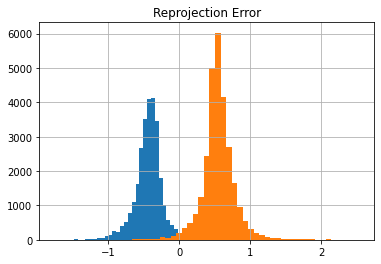

-----------------------------------------
the product turned out negative
['5002-0', '5002-1']


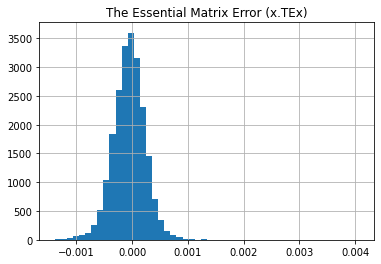

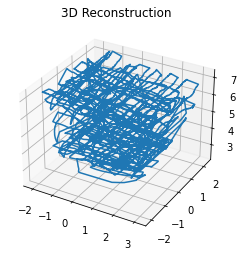

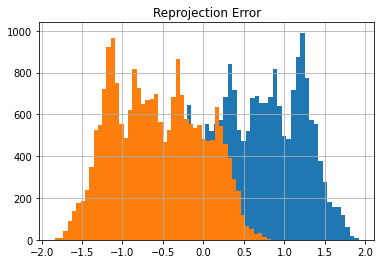

-----------------------------------------


In [5]:
output_dir = 'output/pair_extrinsics/geometrical/'
plots_dir =  'output/plots/pair_extrinsics/geometrical/'

gm_ext = StereoGeometricalCalibrator(cam_data_manager=cam_dm)
#Compute the extrinsics between each pair of camera in the system
for pair in camera_pairs:
    c1, c2 = pair
    #Compute the stereo extrinsics
    K1, K2, E, P1, P2, R, t, points_normalized, error, p1_pix, p2_pix = gm_ext.getExtrinsics(c1,c2)
    params={
        'K1':K1, 
        'K2':K2,
        'E':E,
        'P1':P1,
        'P2':P2,
        'R|T':(R,t),
        'E_error': error,
        'landmarks': points_normalized
    }
    #Save the results to a file
    with open(os.path.join(output_dir, f'ext_{c1}->{c2}.pckl'),'wb') as f:
        pickle.dump(params, f)
    #Plot the results for inspection and visualization
    print(pair)
    _ = plt.hist(error, bins = 50)
    plt.grid(True)
    plt.title('The Essential Matrix Error (x.TEx)')
    plt.savefig(os.path.join(plots_dir, f'essential_mat_error_{c1}->{c2}.png'))
    plt.show()

    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2])
    plt.grid(True)
    plt.title('3D Reconstruction')
    plt.savefig(os.path.join(plots_dir, f'3d_reconstruction_{c1}->{c2}.png'))
    plt.show()
    # Reprojection Statistics
    reprojected1=np.dot(P1,points_normalized.T)
    reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

    reprojected2=np.dot(P2,points_normalized.T)
    reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
    plt.figure()
    _ = plt.hist(np.mean(reprojected1[:,0:2]-p1_pix, axis=-1), bins=50)
    _ = plt.hist(np.mean(reprojected2[:,0:2]-p2_pix, axis=-1), bins=50)
    plt.grid(True)
    plt.title('Reprojection Error')
    plt.savefig(os.path.join(plots_dir, f'reprojection_error_{c1}->{c2}.png'))
    plt.show()
    print('-----------------------------------------')


# Step2: Stereo Extrinsic Refinement with BA
Based on the geometrical extrinsic parameters from the previous section, we initialize a factor graph and compute the bundle adjustment solution of the stereo extrinsic calibration.

['5000-0', '5000-1']


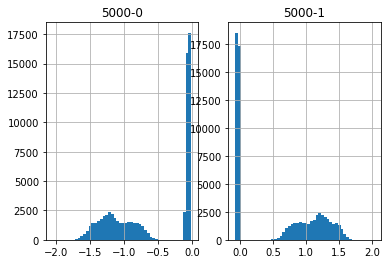

5217.911270389837
Extrinsics Before:
[[ 0.99214823  0.0894791  -0.08738068  0.99606465]
 [-0.08765838  0.99585015  0.02446384 -0.05878409]
 [ 0.08920706 -0.0166121   0.99587456  0.06632982]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.99210935 -0.08763096  0.08966518 -0.99819176]
 [ 0.08979849  0.99575051 -0.02042426 -0.03426415]
 [-0.08749435  0.02831489  0.99576252  0.04416185]
 [ 0.          0.          0.          1.        ]]


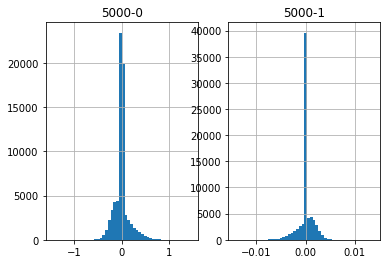

-----------------------------------------
['5000-0', '5001-0']


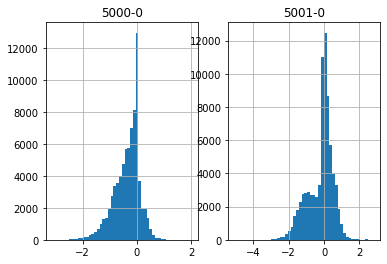

105.19844672409846
Extrinsics Before:
[[-0.99982066 -0.00281473  0.01872788  0.08365375]
 [ 0.01493117  0.49115347  0.87094508 -0.51031119]
 [-0.01164974  0.87106851 -0.49102336  0.85591152]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.9997766   0.01893662 -0.00938873  0.10137835]
 [ 0.00108817  0.48972518  0.87187617 -0.4972179 ]
 [ 0.02110829  0.87167118 -0.48963638  0.86168099]
 [ 0.          0.          0.          1.        ]]


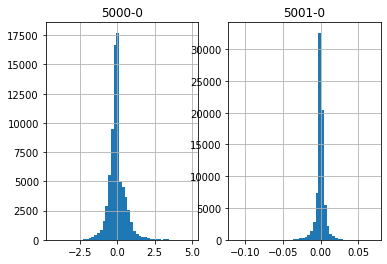

-----------------------------------------
['5000-0', '5001-1']


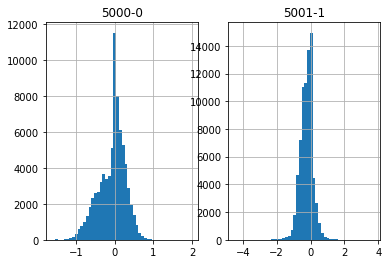

3351.9427071089567
Extrinsics Before:
[[-0.98607386 -0.07490846  0.14848254 -0.07866734]
 [ 0.0964005   0.47007498  0.87734626 -0.50352146]
 [-0.13551858  0.879442   -0.45630744  0.86039386]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.98604738  0.10144695 -0.13198134  0.08645351]
 [-0.06977603  0.46795269  0.88099465 -0.52706061]
 [ 0.15113525  0.87791161 -0.45434496  0.84541914]
 [ 0.          0.          0.          1.        ]]


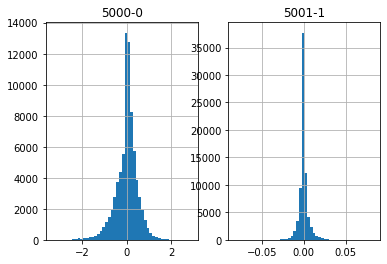

-----------------------------------------
['5000-0', '5002-0']


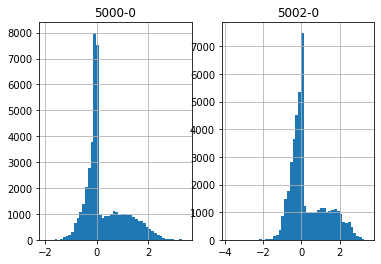

4052.536047905594
Extrinsics Before:
[[ 0.06425631 -0.99592339  0.06330657  0.06653134]
 [ 0.48989611  0.0867481   0.86745408 -0.73812946]
 [-0.86940953 -0.02472576  0.4934731   0.6713706 ]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.06435573  0.48619068 -0.87147976  0.94273193]
 [-0.99609739  0.08415418 -0.02660945  0.14680129]
 [ 0.06040139  0.86979118  0.48970907  0.29941315]
 [ 0.          0.          0.          1.        ]]


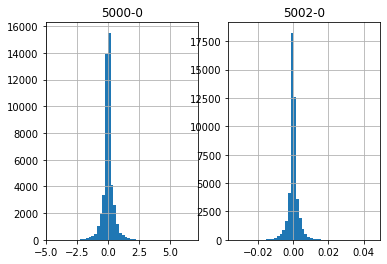

-----------------------------------------
['5000-0', '5002-1']


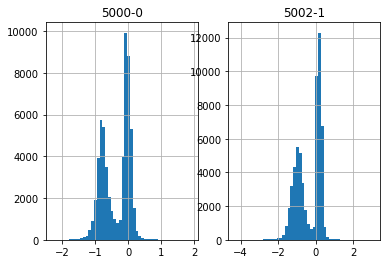

6782.048011865733
Extrinsics Before:
[[ 0.07651614 -0.99566873  0.05281161  0.08414559]
 [ 0.46645354  0.08255917  0.88068444 -0.7643164 ]
 [-0.88123003 -0.04275241  0.47075031  0.63932774]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.07383004  0.46768608 -0.8808058   0.91353458]
 [-0.99567723  0.08447901 -0.03860241  0.17259083]
 [ 0.05635579  0.8798483   0.47190147  0.3683271 ]
 [ 0.          0.          0.          1.        ]]


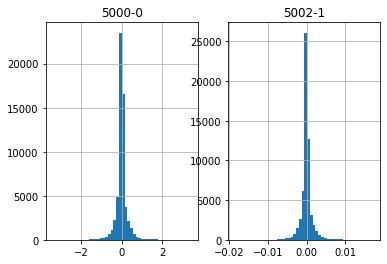

-----------------------------------------
['5000-1', '5001-0']


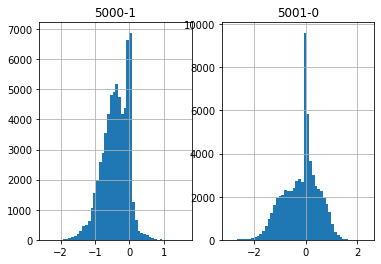

1746.9652713846117
Extrinsics Before:
[[-0.99486147  0.02638926 -0.09774589  0.03663572]
 [-0.07388047  0.47089568  0.87908983 -0.52842119]
 [ 0.06922665  0.88179412 -0.46652632  0.84819153]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.99504176 -0.06798881  0.07259077 -0.06174036]
 [ 0.03194389  0.47272646  0.88063005 -0.49962383]
 [-0.09418856  0.87858251 -0.46821074  0.86403972]
 [ 0.          0.          0.          1.        ]]


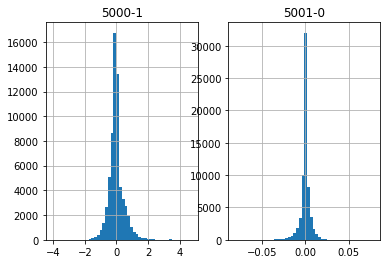

-----------------------------------------
['5000-1', '5001-1']


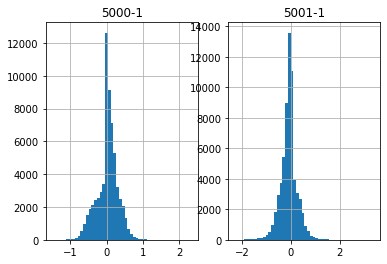

1914.3204784726095
Extrinsics Before:
[[-0.99868802 -0.03876604  0.03345795 -0.12522571]
 [ 0.01258526  0.44752498  0.89418287 -0.52064581]
 [-0.04963719  0.8934308  -0.44644995  0.8445392 ]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.99876469  0.01502935 -0.04736254 -0.07774864]
 [-0.03574222  0.44486216  0.89488555 -0.52658178]
 [ 0.03451936  0.89547294 -0.44377543  0.84656179]
 [ 0.          0.          0.          1.        ]]


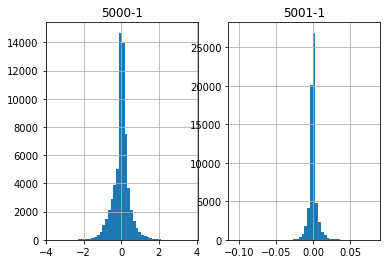

-----------------------------------------
['5000-1', '5002-0']


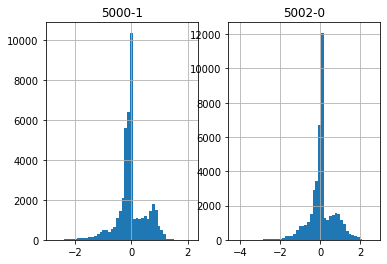

766.144189793888
Extrinsics Before:
[[-5.33736850e-02 -9.98102621e-01  3.06986483e-02 -1.00847118e-01]
 [ 5.06512618e-01 -5.66151091e-04  8.62232363e-01 -7.47604359e-01]
 [-8.60579001e-01  6.15697713e-02  5.05581790e-01  6.56443129e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Extrinsics After:
[[-5.29591747e-02  5.02987655e-01 -8.62669546e-01  9.39700430e-01]
 [-9.98129088e-01 -2.29161026e-04  6.11414044e-02 -1.41406209e-01]
 [ 3.05556814e-02  8.64293565e-01  5.02058745e-01  3.11329404e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


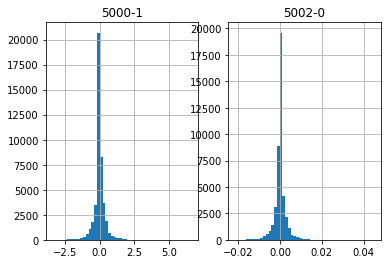

-----------------------------------------
['5000-1', '5002-1']


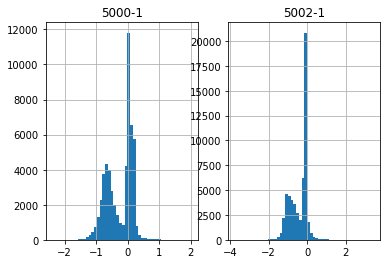

6223.296525433149
Extrinsics Before:
[[-0.04212071 -0.99894382  0.0183602  -0.11878459]
 [ 0.4826647  -0.00425491  0.87579488 -0.77262447]
 [-0.87479176  0.04575093  0.48233414  0.62365187]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.04275378  0.48225272 -0.87498824  0.91178255]
 [-0.99887259 -0.00254712  0.04740318 -0.14974771]
 [ 0.02063161  0.87602844  0.48181793  0.38237405]
 [ 0.          0.          0.          1.        ]]


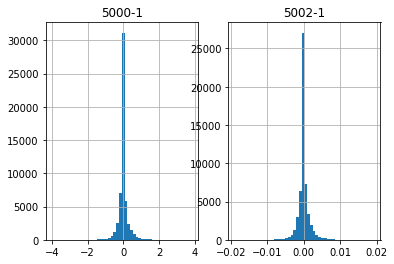

-----------------------------------------
['5001-0', '5001-1']


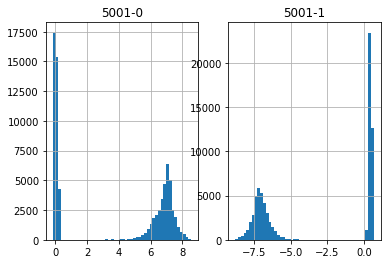

296133.3452762303
Extrinsics Before:
[[ 0.98745223  0.07646181 -0.13817267  0.99663251]
 [-0.06993888  0.99622259  0.05146949  0.00154968]
 [ 0.14158618 -0.04116002  0.98906987  0.08198319]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.98828917 -0.06687811  0.13715626 -0.9967218 ]
 [ 0.07011607  0.99735961 -0.01890859 -0.06388991]
 [-0.13552954  0.02830401  0.99036893  0.04857106]
 [ 0.          0.          0.          1.        ]]


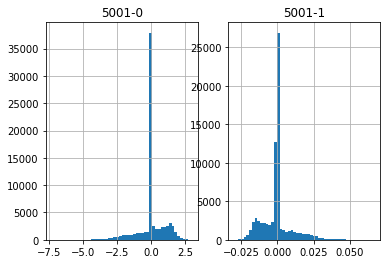

-----------------------------------------
['5001-0', '5002-0']


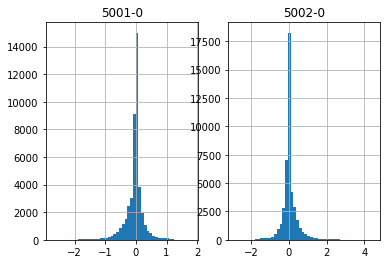

106.62192051586223
Extrinsics Before:
[[-0.04827408  0.99752653 -0.05109237  0.10795734]
 [-0.5145956   0.0190029   0.85722241 -0.75428289]
 [ 0.856073    0.06767353  0.51240541  0.64761295]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.04670512 -0.51523718  0.85577408 -0.9366602 ]
 [ 0.99765167  0.0189059   0.065831   -0.13558735]
 [-0.05009776  0.85683908  0.51314423  0.32291306]
 [ 0.          0.          0.          1.        ]]


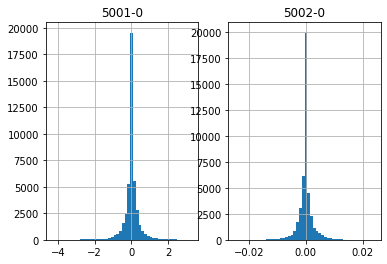

-----------------------------------------
['5001-0', '5002-1']


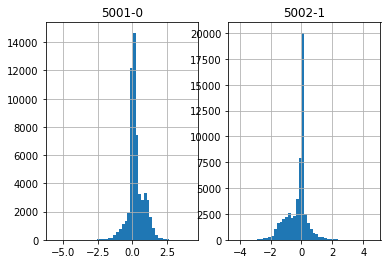

5369.233563249969
Extrinsics Before:
[[-0.05796267  0.99734367 -0.0441127   0.08961858]
 [-0.53389553  0.00636937  0.84552646 -0.73460172]
 [ 0.84356143  0.07256054  0.53210814  0.67255395]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.05726763 -0.53359713  0.84379768 -0.95273225]
 [ 0.99742955  0.00587927  0.07141237 -0.1306677 ]
 [-0.04306635  0.84571836  0.53188885  0.27417236]
 [ 0.          0.          0.          1.        ]]


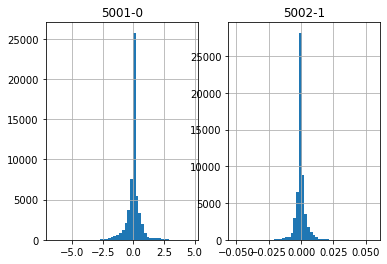

-----------------------------------------
['5001-1', '5002-0']


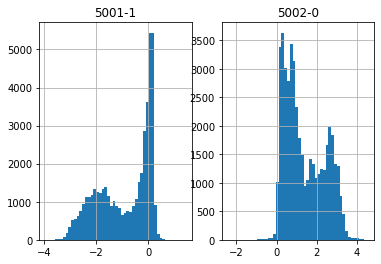

43566.063957085506
Extrinsics Before:
[[ 0.10155467  0.99363334 -0.04877949 -0.09277577]
 [-0.54565897  0.09663433  0.83241702 -0.78614763]
 [ 0.83183108 -0.05791888  0.55199861  0.61103565]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.10176661 -0.54337832  0.8332968  -0.92978749]
 [ 0.99398937  0.08952189 -0.06301557  0.20149879]
 [-0.04035701  0.83470104  0.54922262  0.30797353]
 [ 0.          0.          0.          1.        ]]


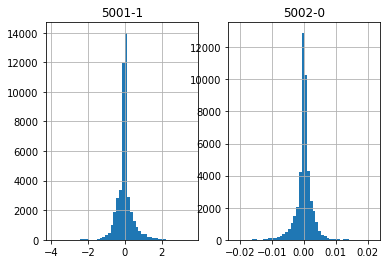

-----------------------------------------
['5001-1', '5002-1']


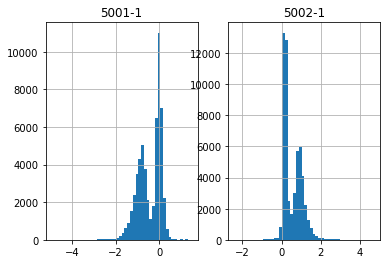

8007.137834101255
Extrinsics Before:
[[ 0.09118476  0.99535023 -0.0310363  -0.07153854]
 [-0.55583482  0.07673056  0.82774396 -0.76118959]
 [ 0.82627658 -0.05822658  0.56024698  0.64457167]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.09096335 -0.55533771  0.82663516 -0.94891925]
 [ 0.99542752  0.07500146 -0.05915099  0.16511911]
 [-0.02915007  0.82823596  0.55962083  0.26885437]
 [ 0.          0.          0.          1.        ]]


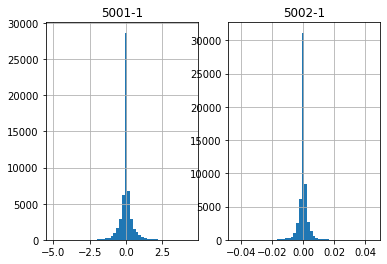

-----------------------------------------
['5002-0', '5002-1']


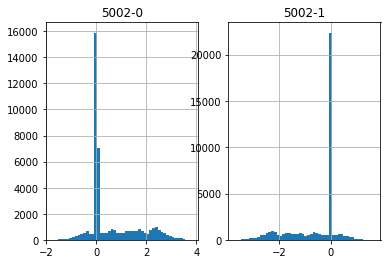

12333.921682269529
Extrinsics Before:
[[ 0.99965741  0.01135621  0.02358196  0.99993094]
 [-0.01162337  0.99986946  0.01122297 -0.01167081]
 [-0.02345143 -0.01149323  0.99965891 -0.00137827]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.99963623 -0.01156197 -0.02436663 -0.99460108]
 [ 0.01135755  0.99989928 -0.00851119  0.00197915]
 [ 0.02446258  0.00823135  0.99966686  0.06112002]
 [ 0.          0.          0.          1.        ]]


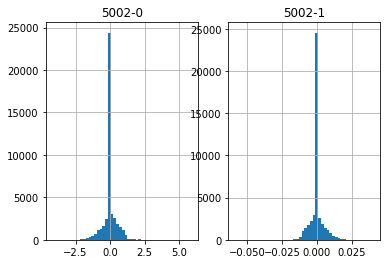

-----------------------------------------


In [8]:
geometrical_extrinsics_params_dir = 'output/pair_extrinsics/geometrical/'
output_dir =   'output/pair_extrinsics/ba'
plot_dir = 'output/plots/pair_extrinsics/ba/'

for pair in camera_pairs:
    print(pair)
    # Load the geometrical extrinsic computed in the previous section
    c1, c2 = pair
    with open(os.path.join(geometrical_extrinsics_params_dir
                           , f'ext_{c1}->{c2}.pckl'),'rb') as f:
        geom_ext = pickle.load(f)
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
    K1, K2 = geom_ext['K1'], geom_ext['K2']
    R,t = geom_ext['R|T']
    
    # Load the camera intrinsic 
    K1 = cam_dm.camModels[c1].P[0:3,0:3]
    K2 = cam_dm.camModels[c2].P[0:3,0:3]
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = cam_dm.getCovisibleMarkerPairs(c1, c2, undist = False, normalized = False)
    # Remove frames where markers are not visible in the pair
    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    # Make an stereo camera object to reconstruct the 3D positions of the landmarks
#     c1 = c1.replace('-','_')
#     c2 = c2.replace('-','_')
    cam1_yaml = f'sample_dataset/intrinsics/{c1}.yaml'
    cam2_yaml = f'sample_dataset/intrinsics/{c2}.yaml'

    stereoCamera = StereoCamera(cam1_yaml, 
                                cam2_yaml, P1, P2)
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]

    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
        
        
    
    plt.savefig(os.path.join(plot_dir, f'{c1}->{c2}_before_ba.pdf'))
    plt.show()
    # Rund the bundle adjustment to improve the quality of calibration
    stereo_ba = StereoBundleAdjustment(R, t, K1, K2)
    stereo_ba.run(x1_undist[:,0:2], x2_undist[:,0:2], landmarks)
    # Compute the reprojection error after BA
    landmarks_opt = np.hstack([stereo_ba.L, np.ones((stereo_ba.L.shape[0],1))]).T
    Pi, Pj = stereo_ba.P1, stereo_ba.P2
    xi_reproj = (Pi @ landmarks_opt).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (Pj @ landmarks_opt).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]

    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    # Plot and save the error distribution after BA
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
        
        
    plt.savefig(os.path.join(plot_dir, f'{c1}->{c2}_after_ba.pdf'))
    plt.show()
    # Save the extrinsics after BA
    params={
        'K1':K1,
        'K2':K2,
        'P1':Pi,
        'P2':Pj,
        'R|T':(stereo_ba.Rj,stereo_ba.tj),
    }
#     assert False
    c2 = c2.replace('_','-')
    c1 = c1.replace('_','-')
    with open(os.path.join(output_dir, f'ext_{c1}->{c2}.pckl'),'wb') as f:
        pickle.dump(params, f)
    print('-----------------------------------------')


# Setep3: Compute the Alignment and Scales

Each pair of cameras provides a point cloud represented in the first camera of the pair. Here, we use the Umeyama algorithm to find the SIM(3) transformation between these point clouds.

## Reconstruct the Point Clouds
First, using the final stereo extrinsic parameters from the BA, we triangulate the marker locations for each pair. 

### Load the Stereo Extrinsic

In [9]:
# All stereo pairs in the system
stereo_parms_dir = 'output/pair_extrinsics/ba/'
params = os.listdir(stereo_parms_dir)
ext_params = {}
for param in params:
    with open(os.path.join(stereo_parms_dir, param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
pprint([key for key in ext_params.keys()])

['5000-1->5001-0',
 '5001-1->5002-1',
 '5000-0->5001-1',
 '5000-0->5001-0',
 '5000-1->5002-1',
 '5000-0->5000-1',
 '5000-0->5002-0',
 '5000-1->5001-1',
 '5001-1->5002-0',
 '5000-1->5002-0',
 '5000-0->5002-1',
 '5001-0->5002-0',
 '5001-0->5001-1',
 '5002-0->5002-1',
 '5001-0->5002-1']


### Load the Marker Observations

In [10]:
# Take the 5002-0 as the reference camera against which all other cameras are synchronized
sync_pixels = cam_dm.getSynchronizedSamples('5002-0', undist=False)
sync_pixels.keys()
sync_pixels['5002-1'].shape

(48237, 2)

5000-1->5001-0


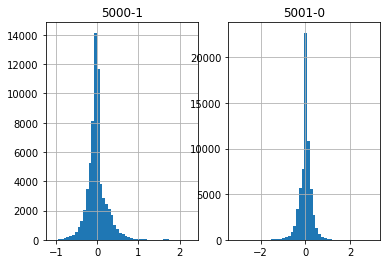

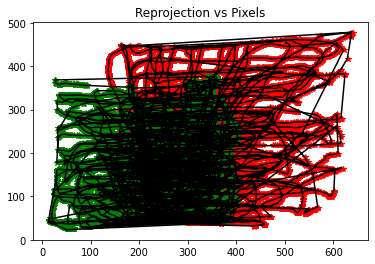

-----------------------------------------
5001-1->5002-1


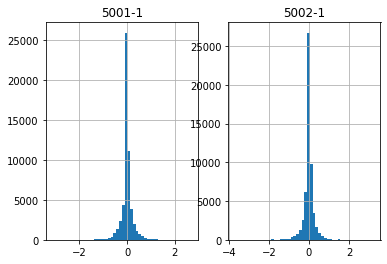

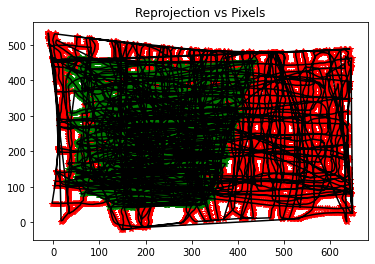

-----------------------------------------
5000-0->5001-1


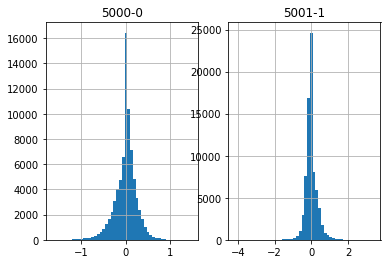

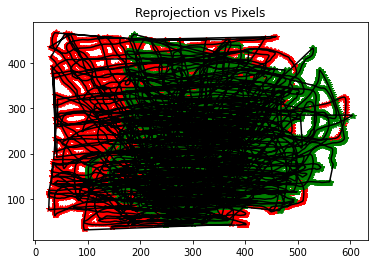

-----------------------------------------
5000-0->5001-0


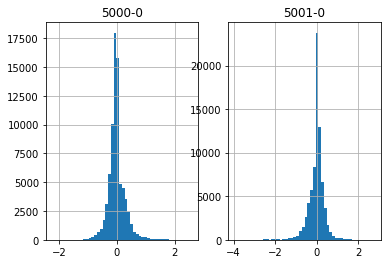

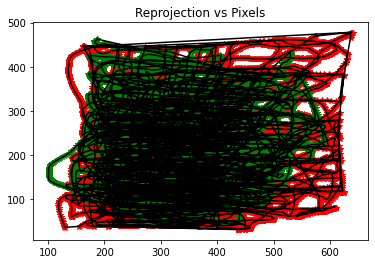

-----------------------------------------
5000-1->5002-1


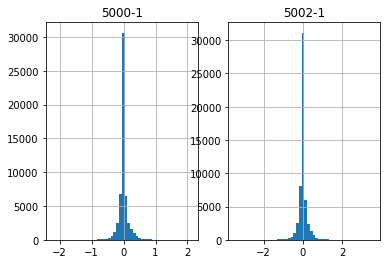

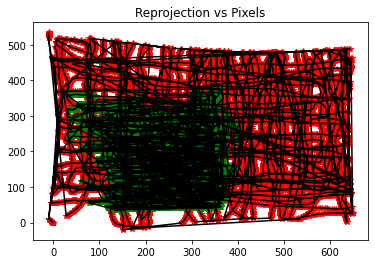

-----------------------------------------
5000-0->5000-1


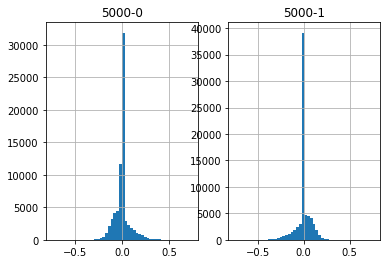

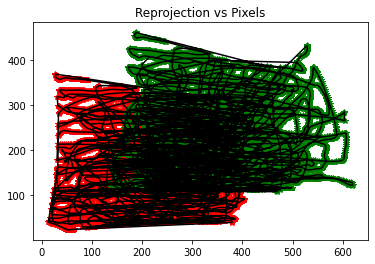

-----------------------------------------
5000-0->5002-0


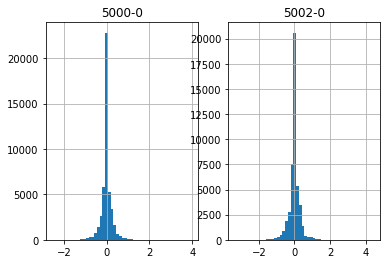

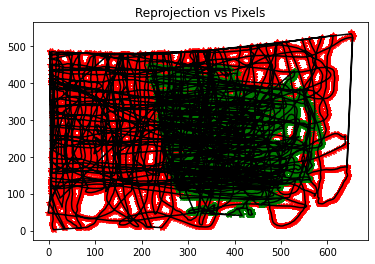

-----------------------------------------
5000-1->5001-1


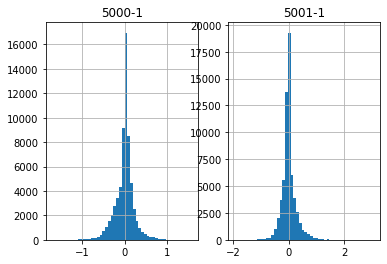

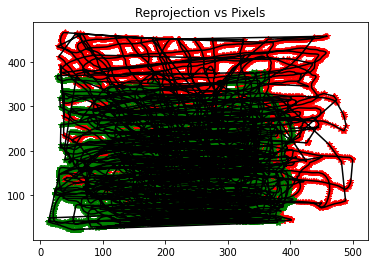

-----------------------------------------
5001-1->5002-0


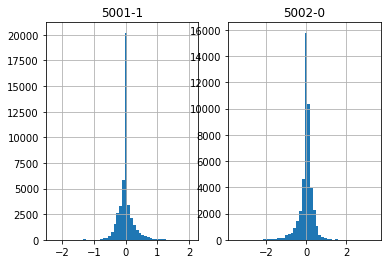

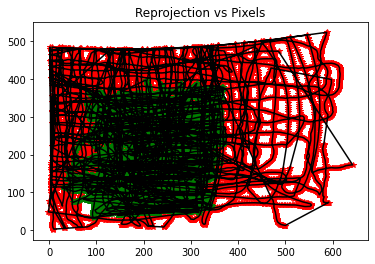

-----------------------------------------
5000-1->5002-0


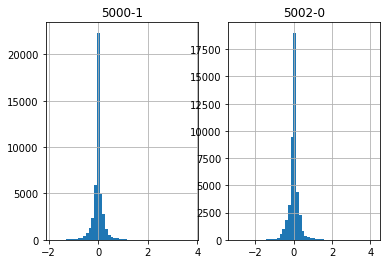

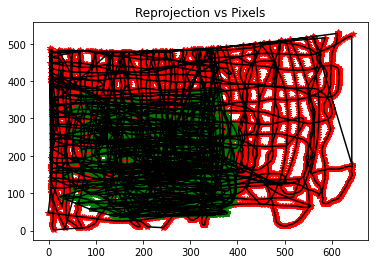

-----------------------------------------
5000-0->5002-1


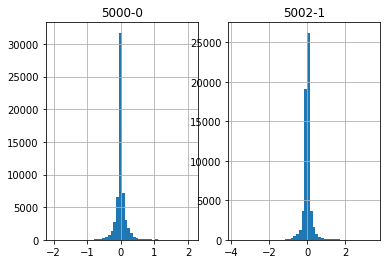

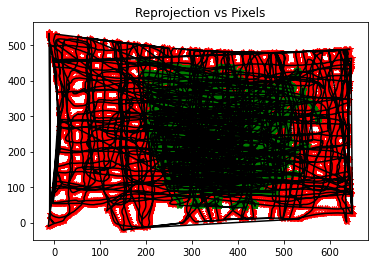

-----------------------------------------
5001-0->5002-0


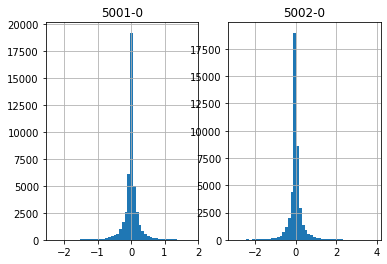

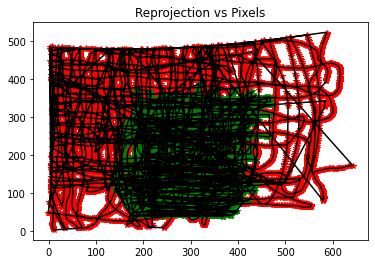

-----------------------------------------
5001-0->5001-1


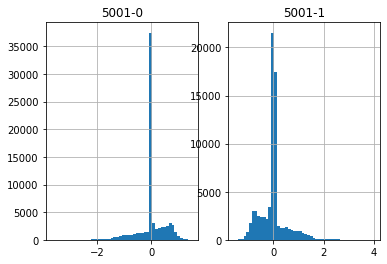

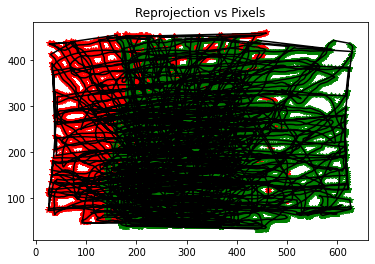

-----------------------------------------
5002-0->5002-1


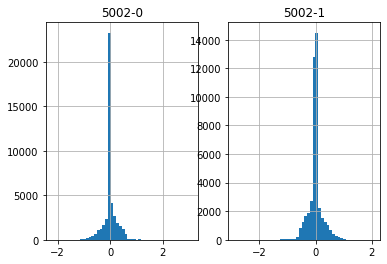

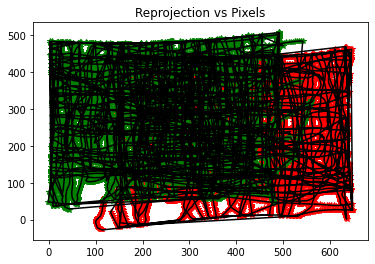

-----------------------------------------
5001-0->5002-1


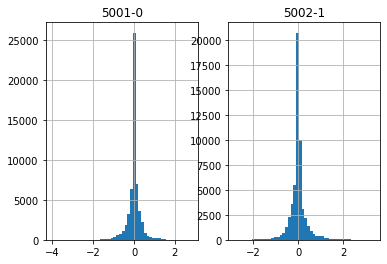

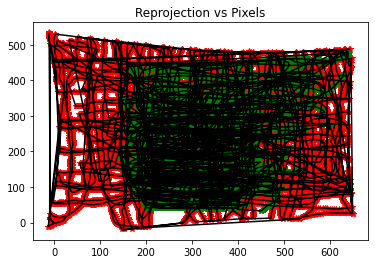

-----------------------------------------


In [11]:
stereo_parms_dir = 'output/pair_extrinsics/ba/'
camera_intrinsics_dir = 'sample_dataset/intrinsics'

results = {}
for pair in ext_params.keys():
    print(pair)
    # Load the geometrical extrinsics computed in the previous section
    c1, c2 = pair.split('->')
    # Load the camera intrinsics 
#     c1 = c1.replace('_','-')
#     c2 = c2.replace('_','-')
#     K1 = cam_dm.camModels[c1].P[0:3,0:3]
#     K2 = cam_dm.camModels[c2].P[0:3,0:3]
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = sync_pixels[c1], sync_pixels[c2]
    result = -np.ones((x1.shape[0],3))
    reprojection_error = np.ones((x1.shape[0]))

    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    
#     c1 = c1.replace('-','_')
#     c2 = c2.replace('-','_')
    
    #Load the extrinsic parametes 
    with open(os.path.join(stereo_parms_dir, f'ext_{c1}->{c2}.pckl'),'rb') as f:
        geom_ext = pickle.load(f)
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
    R,t = geom_ext['R|T']
   
    # Make a stereo camera object to reconstruct the 3D positions of the landmarks
    cam1_yaml = os.path.join(camera_intrinsics_dir,f'{c1}.yaml')
    cam2_yaml = os.path.join(camera_intrinsics_dir,f'{c2}.yaml')
    
    stereoCamera = StereoCamera(cam1_yaml, cam2_yaml, P1, P2)
    
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    result[idx,...]=landmarks.squeeze()[:,0:3]
    
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]
    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    reprojection_error[idx,...] = (np.linalg.norm(xj_reproj - x2_undist[:,0:2], axis = -1)+
                          np.linalg.norm(xi_reproj - x1_undist[:,0:2], axis = -1))/2

    # Plot the reprojection error distribution
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
    plt.show()
    
    # Plot the reprojections of the landmarks on the image
    plt.figure()
    plt.title('Reprojection vs Pixels')
    plt.plot(xj_reproj[:,0],xj_reproj[:,1],'r*')
    plt.plot(xi_reproj[:,0],xi_reproj[:,1],'g*')
    plt.plot(x1_undist[:,0],x1_undist[:,1],'k')
    plt.plot(x2_undist[:,0],x2_undist[:,1],'k')
    plt.show()
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
    results[f'{c1}->{c2}']={'landmarks':result, 'error':reprojection_error.reshape(-1,1)}
    print('-----------------------------------------')


In [12]:
from pprint import pprint
pprint([f'pair {key}: {[k for k in results[key].keys()]}' for key in results.keys()])

["pair 5000-1->5001-0: ['landmarks', 'error']",
 "pair 5001-1->5002-1: ['landmarks', 'error']",
 "pair 5000-0->5001-1: ['landmarks', 'error']",
 "pair 5000-0->5001-0: ['landmarks', 'error']",
 "pair 5000-1->5002-1: ['landmarks', 'error']",
 "pair 5000-0->5000-1: ['landmarks', 'error']",
 "pair 5000-0->5002-0: ['landmarks', 'error']",
 "pair 5000-1->5001-1: ['landmarks', 'error']",
 "pair 5001-1->5002-0: ['landmarks', 'error']",
 "pair 5000-1->5002-0: ['landmarks', 'error']",
 "pair 5000-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5002-0: ['landmarks', 'error']",
 "pair 5001-0->5001-1: ['landmarks', 'error']",
 "pair 5002-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5002-1: ['landmarks', 'error']"]


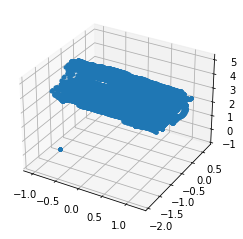

In [13]:
#Plot one of the reconstructions for sanity check
# %matplotlib
pair = '5000-0->5000-1'
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(results[pair]['landmarks'][:,0],
          results[pair]['landmarks'][:,1],
          results[pair]['landmarks'][:,2], '.')
plt.show()

## Align the Pointclouds

Now, we use the Umeyama algorithm to find the SIM(3) transformations between the point cloud generated by each pair and that of generated from an arbitrary reference pair.  

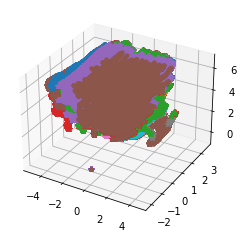

In [15]:
from src.rpg_trajectory_evaluation.align_trajectory import *
ref_pair = '5002-0->5002-1'
P1 = results[ref_pair]['landmarks'] #reference point cloud

alignment_params = {}

plt.figure()
ax = plt.axes(projection='3d')
reconstructions_aligned = []

for pair in results:
    P2 = results[pair]['landmarks']
    
    invisible_idx = np.where(P2==[-1,-1,-1])[0]
    a_with_marker = np.sum(P1,axis=-1)!=-3
    b_with_marker = np.sum(P2,axis=-1)!=-3
    a_b_with_marker = np.logical_and(a_with_marker, b_with_marker)
    idx = np.where(a_b_with_marker)
    
    A = P1[a_b_with_marker,:]
    B = P2[a_b_with_marker,:]

    s, R, t = align_umeyama(A,B)
    alignment_params[f'{ref_pair}_{pair}'] = {'s':s, 'R':R, 't':t}
    
    P2_prime =( s * R @ P2.T + t.reshape(3,1)).T
    P2_prime[invisible_idx,:] = -np.ones((1,3))
    
    reconstructions_aligned.append(P2_prime)
    ax.plot3D(P2_prime[:,0],P2_prime[:,1],P2_prime[:,2],'*')
    
ax.plot3D(P1[:,0],P1[:,1],P1[:,2],'.')

with open('output/alignment/pair_alignments.pckl', 'wb') as f:
    pickle.dump(alignment_params,f)


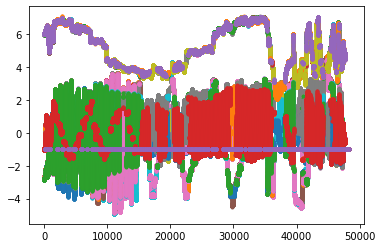

In [16]:
for path in reconstructions_aligned:
    plt.plot(path,'.')

# Step4: Fuse the Aligned Point Clouds

In this section, we make a unified point cloud as the average of all the aligned point clouds from the previous step.

In [17]:
pcs = []

for pc in reconstructions_aligned:  
    #Zero out samples with no marker (indicated with [-1, -1, -1])
    idx_null = np.where(np.all(pc==-1, axis = -1))[0]
    #Scale the point cloud
    pc[idx_null,...] = [0, 0, 0]
    pcs.append(pc)
        
pcs = np.stack(pcs)
#How many valid samples do we have for each time stamp
avg_den = np.count_nonzero(np.all(pcs!=0, axis = -1), axis = 0).reshape(-1,1)
#Compute the average for each time stamp and avoid dividing by zero if no markers are visible
fused_pc = np.sum(pcs, axis = 0)
#Note, we should not divide by zero
fused_pc[np.where(avg_den!=0)[0]] /= avg_den[np.where(avg_den!=0)[0]]
#reset the indication value of no maker visible samples to -1s
fused_pc[np.where(avg_den==0)[0],...]=[-1,-1,-1]

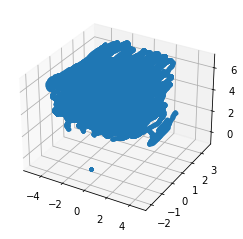

In [18]:
#Plot one of the reconstructions for sanity check
# %matplotlib
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(fused_pc[:,0],
          fused_pc[:,1],
          fused_pc[:,2], '.')
plt.show()

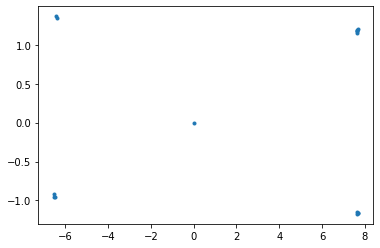

In [21]:
ca = np.vstack([alignment_params[k]['t'] for k in alignment_params.keys()])

plt.plot(ca[:,0],ca[:,1],'.')

# Step5: Unify the Scales of the Stereo Extrinsic

Now, we use the scale parameter from the alignment step and generate a set of stereo extrinsic with unified baseline scales.

In [22]:
output_dir = 'output/pair_extrinsics/ba_scaled/'
ext_params_dir = 'output/pair_extrinsics/ba/'
alignment_params_file = 'output/alignment/pair_alignments.pckl'
#Load the unscaled stereo extrinsic paramters
params = os.listdir(ext_params_dir)
stereo_exts = {}
for param in params:
    with open(os.path.join(ext_params_dir, param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
# Load the alignment parameters that we saved previously       
with open(alignment_params_file,'rb') as f:
    alignment_params = pickle.load(f)
        
for key in alignment_params.keys():
    pair = key.split('_')[1]
    s = alignment_params[key]['s']
    c1 , c2 = pair.split('->')
#     c1 = c1.replace('-','_')
#     c2 = c2.replace('-','_')
    R_c1_c2, t_c1_c2 = ext_params[f'{c1}->{c2}']['R|T']
    
    t_c1_c2 = t_c1_c2*s#Scale the pair baseline
    T_c1_c2 = np.vstack([np.hstack([R_c1_c2, t_c1_c2]),
                              np.array([0,0,0,1]).reshape(1,4)])
    
    ext_params[f'{c1}->{c2}']['R|T'] = (R_c1_c2, t_c1_c2)
    P1 = ext_params[f'{c1}->{c2}']['K1']@np.hstack([np.eye(3), np.zeros((3,1))])
    P2 = ext_params[f'{c1}->{c2}']['K2']@np.hstack([R_c1_c2, t_c1_c2])
    
    ext_params[f'{c1}->{c2}']['P1'] = P1
    ext_params[f'{c1}->{c2}']['P2'] = P2
    
# Save the resulting scaled extrinsics  
for pair in ext_params.keys():
    file_name = f'ext_{pair}.pckl'
    with open(os.path.join(output_dir, file_name), 'wb') as f:
        pickle.dump(ext_params[pair], f)
        
ext_params['5001-1->5002-1']

{'K1': array([[518.97156,   0.     , 285.90353],
        [  0.     , 518.17914, 279.16011],
        [  0.     ,   0.     ,   1.     ]]),
 'K2': array([[555.98596,   0.     , 460.21948],
        [  0.     , 621.04614, 253.885  ],
        [  0.     ,   0.     ,   1.     ]]),
 'P1': array([[518.97156,   0.     , 285.90353,   0.     ],
        [  0.     , 518.17914, 279.16011,   0.     ],
        [  0.     ,   0.     ,   1.     ,   0.     ]]),
 'P2': array([[ 3.71589176e+01,  7.24103505e+01,  7.17145950e+02,
         -3.16958110e+03],
        [ 6.10805652e+02,  2.56856052e+02,  1.05343841e+02,
          1.34053298e+03],
        [-2.91500672e-02,  8.28235960e-01,  5.59620826e-01,
          2.11006019e+00]]),
 'R|T': (array([[ 0.09096335, -0.55533771,  0.82663516],
         [ 0.99542752,  0.07500146, -0.05915099],
         [-0.02915007,  0.82823596,  0.55962083]]),
  array([[-7.44743969],
         [ 1.29591072],
         [ 2.11006019]]))}

# Step6: Bundle Adjustment for All Cameras

In this section, we use the geometrical estimation from the previous parts and jointly refine the calibration parameters and the camera poses. The factor graph generated in this section as constructed from the stereo extrinsic paramters between the pairs of camera in the system plus general projection factors that connect them to observed landmarks. 

The stereo extrinsic parameters are enforced through the *betweenFactors* and the projection of the marker to each camera is modeled using GTSAM's *GenericProjectionFactorCal3_S2* factors. 

In [42]:
calib_data = '/media/robocaster/13a60227-5511-4ad6-893b-dd4e8545305b/aras-cam-dataset/raw-dataset/uwb_dataset/uwb_jul29/ir_tracker_calibration/recorded-2021-12-02-12:52:00_input.pckl'

cam_dm = cameraDataManager(calib_data, 
                           'sample_dataset/intrinsics/',ports = [5000, 5001, 5002], data_idx= 3)  

synchronized_paths = cam_dm.getSynchronizedSamples('5002-0',undist=True)

In [25]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

class multiCameraBA():
    def __init__(self, extrinisics_dir, camera_dm, ref_camera = '5002-0'):
        self.reference_camera = ref_camera
        #Load the geometrical extrinsic parameters calculated from the previous section
        self.loadParams(extrinisics_dir) 
        #Extract the keys
        self.extractExtrinsicKeys(self.ext_params)
        #Load the camera parameters as GTSAM Cal3_S2 objects 
        camModels = cam_dm.camModels
        self.Ks = {key:gtsam.Cal3_S2(camModels[key].P[0,0], camModels[key].P[1,1], 0, \
                                     camModels[key].P[0,2], camModels[key].P[1,2]) \
                   for key in camModels.keys()}
        
        # Here, we're assuming identical noises for all cameras (0.5 pixels)
        self.camNoises = {key:gtsam.noiseModel.Isotropic.Sigmas( np.array([0.2, 0.2])) 
                          for key in camModels.keys()}
        
        noise = gtsam.noiseModel.Isotropic.Sigmas(np.vstack([np.ones((3,1))*2,
                                             np.ones((3,1))*2]))
        #Add uncertainties for the relative camera poses
        self.relativePoseNoises = {pair:noise for pair in self.pair_keys}
 
    def loadParams(self, ext_params_dir):
        '''Get the path to the extrinsic parameter files and store them as a dictionary'''
        param_file_names = os.listdir(ext_params_dir)
        ext_params = {}
        
        for param_file in param_file_names:

            with open(os.path.join(ext_params_dir, param_file), 'rb') as f:
                ext_params[param_file.split('.')[0].split('ext_')[-1]] = pickle.load(f) 
        
        self.ext_params = ext_params        
                
    def extractExtrinsicKeys(self, ext_params):
        #Extract all extrinsic pairs
        self.pair_keys = [k for k in ext_params.keys()]
        #What camera IDs do we have?
        all_keys = np.stack([k.split('->') for k in ext_params.keys()]).reshape(-1)
        
        self.cam_ids = []     
        _ = [self.cam_ids.append(key) if key not in self.cam_ids else None for key in all_keys]
        #Make dictionaries to convert camera IDs to pose keys
        self.cam_id_to_key = {i:key for i,key in enumerate(self.cam_ids)}
        self.key_to_cam_id = {key:i for i,key in enumerate(self.cam_ids)}
        
    def addUnaryPosePrior(self, T, noise, key):
        self.graph.push_back(gtsam.PriorFactorPose3(key, T, noise))         

    def addProjectionFactor(self, K, z, noise, camera_key, landmark_key):
        self.graph.push_back(gtsam.GenericProjectionFactorCal3_S2( z.reshape(2,1),noise, camera_key, landmark_key, K))
        
    def addRelativePoseConstraints(self, pair):
        cam_i, cam_j = map(lambda x:self.key_to_cam_id[x], pair.split('->'))
        R,t = self.ext_params[pair]['R|T']
        
        relative_pose = gtsam.Pose3(gtsam.Rot3(R), t)
        self.graph.push_back(
            gtsam.BetweenFactorPose3(X(cam_j), X(cam_i), relative_pose, self.relativePoseNoises[pair]) )
    
    def getCameraPose(self, key):
        return gtsam.Pose3()
    
    def estimateCameraPoses(self):
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()

            for pair in self.pair_keys:
                self.addRelativePoseConstraints(pair)
                
            for key in self.key_to_cam_id:
                self.initial.insert(X(self.key_to_cam_id[key]), gtsam.Pose3())
                
            self.addUnaryPosePrior(gtsam.Pose3(),gtsam.noiseModel.Isotropic.Sigma(6,0.0002)  , 
                                   X(self.key_to_cam_id[self.reference_camera]))
            
            params = gtsam.GaussNewtonParams()
            optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, result)
            
            means = {}
            covariances = {}
            for key in self.key_to_cam_id:
                R = result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,0:3].reshape(3,3)
                t = result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,-1] 
                means[key] = gtsam.Pose3(gtsam.Rot3(R), t)
                covariances[key] = gtsam.noiseModel.Gaussian.Covariance(marginals.marginalCovariance(X(self.key_to_cam_id[key])))
            self.camPoseMeans = means
            self.camPoseCovariances = covariances
            return means, covariances
            
    
    def run(self, pixels, recons_init):
            '''Take the synchronized pixels and the intial reconstructions from 
               the geometrical method and preform BA'''
            
            means, covariances = self.estimateCameraPoses()
            
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()
            
            for key in means.keys():
                self.addUnaryPosePrior(means[key], covariances[key], X(self.key_to_cam_id[key]))
                self.initial.insert(X(self.key_to_cam_id[key]), means[key])
            
            pixel_keys = [key for key in pixels]
            num_of_landmarks = pixels[pixel_keys[0]].shape[0]

            l_index = 0
            self.lz_index_map = {}
            for n in range(num_of_landmarks):
                #Extract the current observation i for all camera
                z = np.stack([pixels[key][n,...] for key in pixel_keys])
                p_init = recons_init[n,...]

                # How many cameras can see the marker at this moment?
                visibility_number = np.count_nonzero(np.all(z!=-1, axis = -1))
                # Add the landmark to the graph only if at least two cameras can simultaneously see the marker
                if visibility_number > 1:
#                   Add the valid landmark observations to the graph
                    for i,key in enumerate(pixel_keys):
                        if np.all(z[i,...]!=-1, axis=-1): # The marker should be visible by at least two cameras 
#                             print(f'Adding observation of camera {key} to the graph.')

                            self.addProjectionFactor(self.Ks[key], z[i,:], self.camNoises[key],\
                                                 X(self.key_to_cam_id[key]), L(l_index))
#                             print(f'Connecting landmark L({l_index}) to X({self.key_to_cam_id[key]})')

                    self.initial.insert(L(l_index), gtsam.Point3(x=p_init[0], y=p_init[1], z=p_init[2]))
                    self.lz_index_map[l_index] = n
                    l_index+=1
                            
    

            params = gtsam.GaussNewtonParams()
            optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            self.result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, self.result)
            i = 0
            self.L = []
            self.R = self.result.atPose3(X(1)).matrix()[0:3,0:3].reshape(3,3)
            self.t = self.result.atPose3(X(1)).matrix()[0:3,-1] 
            for i in range(l_index):
                if self.result.exists(L(i)):
                    self.L.append(self.result.atPoint3(L(i)))
            self.L = np.stack(self.L)
            camPoses = {}  
            camCovariances = {}
            for key in self.key_to_cam_id:
                R = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,0:3].reshape(3,3)
                t = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,-1] 
                camPoses[key] = gtsam.Pose3(gtsam.Rot3(R), t).matrix()
                camCovariances[key] = gtsam.noiseModel.Gaussian.Covariance(
                    marginals.marginalCovariance(X(self.key_to_cam_id[key]))).covariance() 
            return camPoses, camCovariances

In [26]:
ds_ratio = 1
synchronized_paths_ds = {}
idx_ds = [i*ds_ratio for i in range(fused_pc.shape[0]//ds_ratio)]
fused_pc_ds = fused_pc[idx_ds,...]

for key in synchronized_paths:
    synchronized_paths_ds[key] = synchronized_paths[key][idx_ds,...]

In [27]:
ba = multiCameraBA('output/pair_extrinsics/ba_scaled/', cam_dm)
camPoses, camCovariances = ba.run(synchronized_paths_ds,fused_pc_ds)

Show the camera poses and estimated landmark positions in a 3D scene.

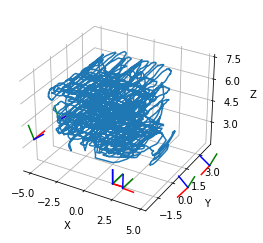

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager


random_state = np.random.RandomState(0)

cam_poses = [pt.transform_from_pq(np.hstack((camPoses[key][0:3,-1],
               pr.quaternion_from_matrix(camPoses[key][0:3,0:3]) ))) for key in camPoses.keys()]


tm = TransformManager()
for i,pose in enumerate(cam_poses):
    tm.add_transform(f"cam{i}", "world", pose)
    
ax = tm.plot_frames_in("world", s=1, show_name=False)
ax.set_xlim((min(ba.L[:,0])-0.5, max(ba.L[:,0])+0.5))
ax.set_ylim((min(ba.L[:,1])-0.5, max(ba.L[:,1])+0.5))
ax.set_zlim((min(ba.L[:,2])-0.5, max(ba.L[:,2])+0.5))
ax.plot3D(ba.L[:,0], ba.L[:,1], ba.L[:,2])
plt.show()

Finally, save the refined camera poses and covariances for later use with the reconstruction and tracking tasks.

In [30]:
output_dir = 'output/alignment/'
camera_poses = {'mean':camPoses, 'cov':camCovariances}
with open(os.path.join(output_dir, 'cam_poses.pckl'), 'wb') as f:
    pickle.dump(camera_poses, f)

# Sanity Check
The check the correctness of the estimated camera poses and landmark 3D positions, reproject the landmarks back on the the image planes and compare against the real observations (camera pixels). Ideally, these two sets of positions must be as close as possible.

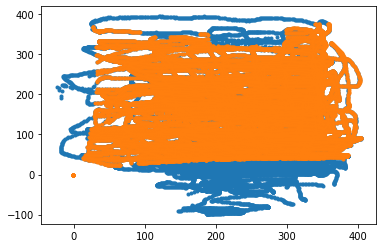

In [41]:
landmarks  = np.hstack([ba.L, np.ones((ba.L.shape[0],1))])

T = np.linalg.inv(camPoses['5000-1'])
R = T[0:3, 0:3]
t = T[0:3, -1]
P1 = cam_dm.camModels['5000-1'].P[0:3,0:3]
P1 = P1@np.hstack([R,t.reshape(3,1)])
xi_reproj = (P1 @ landmarks.T).T
xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

plt.plot(xi_reproj[:,0], xi_reproj[:,1],'.')
plt.plot(synchronized_paths['5000-1'][:,0], synchronized_paths['5000-1'][:,1],'.')